In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class Neural_Network:
    def __init__(self, InputSize=784, HiddenLayers=[512, 512], OutputSize=10):
        self.InputSize=InputSize
        self.HiddenLayers=HiddenLayers
        self.OutputSize=OutputSize
        self.weights=[]
        self.bias=[]
        self.values=[]
        self.z_values=[]

    def RandomiseNetwork(self):
        #generating weights for input to hidden layers
        self.weights.append(np.random.randn(self.InputSize, self.HiddenLayers[0]) * np.sqrt(1 / self.InputSize))
        self.bias.append(np.zeros((1, self.HiddenLayers[0])))

        #generating weights for all hidden layers
        for x in range(len(self.HiddenLayers) - 1):
            self.weights.append(np.random.randn(self.HiddenLayers[x], self.HiddenLayers[x+1]) * np.sqrt(1 / self.HiddenLayers[x]))
            self.bias.append(np.zeros((1, self.HiddenLayers[x+1])))

        #generating weights for hidden layers to output
        self.weights.append(np.random.randn(self.HiddenLayers[-1], self.OutputSize) * np.sqrt(1 / self.HiddenLayers[-1]))
        self.bias.append(np.zeros((1, self.OutputSize)))
    
    #Derivative of the Sigmoid Activation Function
    def SigmoidDer(self, x):
        # s = self.Sigmoid(x)
        # return s * (1 - s)
        return (x > 0).astype(float)

    #Sigmoid Activation Function 
    def Sigmoid(self, x):
        # return 1 / (1+np.exp(-x))
        return np.maximum(0, x)
    
    #Softmax Activation function applied at output
    def SoftMaxActivation(self, x):
        x = x - np.max(x, axis=1, keepdims=True)
        return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)
        
    #Probabiilty Distribution of the predicted number
    def show_probability_plot(self, output):
        numbers = np.arange(10)

        plt.figure(figsize=(8, 4))
        plt.bar(numbers, output[0], color='skyblue', edgecolor='black')

        # Labels and title
        plt.xlabel('Number')
        plt.ylabel('Probability')
        plt.title('Probability Distribution of Numbers 0 to 9')
        plt.xticks(numbers)

        # Show the plot
        plt.show()
    
    def ForwardPass(self, inputs):
        self.values = [inputs]
        self.z_values = []

        #Dot product the whole layer, apply a sigmoid activation function and then input to activations array
        for x in range(len(self.weights)):
            z=np.dot(self.values[-1], self.weights[x]) + self.bias[x]
            self.z_values.append(z)

            if x == len(self.weights) - 1:
                a = self.SoftMaxActivation(z)
            else:
                a = self.Sigmoid(z)

            self.values.append(a)

        #set output to class values and return output layer
        self.values=self.values
        return self.values[-1]
    
    def BackwardsPropogation(self, y, output):

        change_weights = []
        change_bias = []

        delta = output - y

        #output layer
        for x in reversed(range(len(self.weights))):
            previous_activations = self.values[x].reshape(1, -1)

            del_weights = np.dot(previous_activations.T, delta)
            del_bias = np.sum(delta, axis=0, keepdims=True)

            change_weights.insert(0, del_weights)
            change_bias.insert(0, del_bias)

            if x > 0:
                previous_z_values = self.z_values[x - 1]
                delta = np.dot(delta, self.weights[x].T) * self.SigmoidDer(previous_z_values)

        return change_weights, change_bias
        
    def UpdateNetwork(self, change_weights, change_bias, learning_rate):
        for i in range(len(self.weights)):
            self.weights[i] -= learning_rate * change_weights[i]
            self.bias[i] -= learning_rate * change_bias[i]

    def DetermineCategoricalCrossEntropy(self, output, label):
        numbers = np.eye(10)[label]
        return -np.sum(numbers * np.log(output + 1e-9))

    def IdentifyNum(self, output):
        return np.argmax(output)


In [421]:
gerald = Neural_Network()
gerald.RandomiseNetwork()

In [422]:
# Load the CSV (assumes header row)
data = np.load('./mnist_train.npy')

# Separate labels and image pixel data
labels = data[:, 0]          # First column: labels
images = data[:, 1:]         # Remaining columns: 784 pixels

In [423]:
#Training
batch_size = 16
batches = 2000

#randomise
perm = np.random.permutation(len(images))
images = images[perm]
labels = labels[perm]

rando = 0

losses = []

for indent in range(batches):

    weight_grads = [np.zeros_like(w) for w in gerald.weights]
    bias_grads = [np.zeros_like(b) for b in gerald.bias]

    for i in range(batch_size):
        idx = indent * batch_size + i
        input_values = images[idx] / 255.0  # Normalize input
        y = np.eye(10)[labels[idx]].reshape(1, 10)
        
        #do all permutations to network
        output = gerald.ForwardPass(input_values)
        
        # if rando <= 10:
        #     gerald.show_probability_plot(output)
        #     rando += 1
            
        # gerald.DetermineCategoricalCrossEntropy(output[0], labels[idx])

        grad_w, grad_b = gerald.BackwardsPropogation(y, output)

        for l in range(len(gerald.weights)):
            weight_grads[l] += grad_w[l]
            bias_grads[l] += grad_b[l]

    # Average the gradients
    for l in range(len(gerald.weights)):
        weight_grads[l] /= batch_size
        bias_grads[l] /= batch_size

    # Update weights
    gerald.UpdateNetwork(weight_grads, bias_grads, 0.1)

    loss = gerald.DetermineCategoricalCrossEntropy(gerald.ForwardPass(images[batch_size * indent] / 255.0), labels[batch_size * indent])
    # gerald.show_probability_plot(gerald.ForwardPass(images[batch_size * indent] / 255.0))
    losses.append(loss)

    # print(gerald.DetermineCategoricalCrossEntropy(gerald.SoftMaxActivation(gerald.ForwardPass(images[batch_size*indent] / 255.0 )), labels[batch_size*indent]))

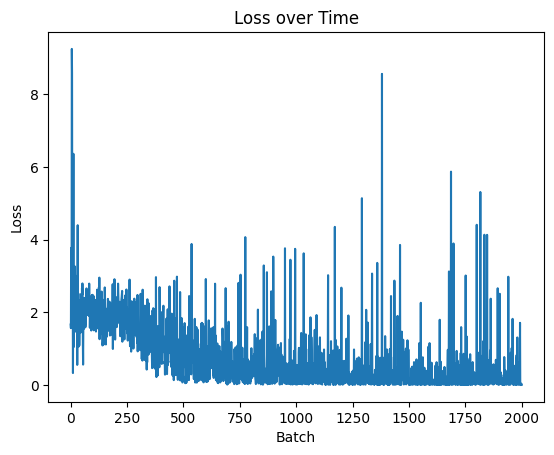

0.001521338418542389


In [424]:
plt.plot(losses)
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Loss over Time")
plt.show()
print(losses[-1])

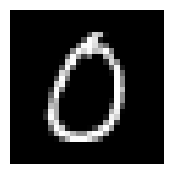

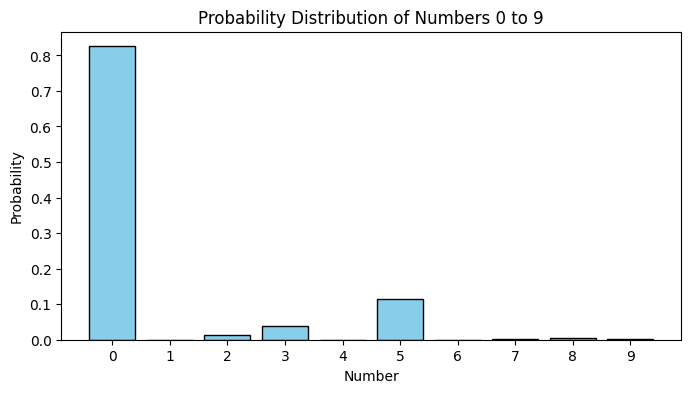

0

In [425]:
#test
idx = 870
input_values = images[idx] / 255.0  # Normalize input
y = np.eye(10)[labels[idx]].reshape(1, 10)

# Display the image
plt.figure(figsize=(2, 2))
plt.imshow(input_values.reshape(28, 28), cmap='gray', interpolation='none')
plt.axis('off')
plt.show()

output = gerald.ForwardPass(input_values)
gerald.show_probability_plot(output)
gerald.IdentifyNum(output)

In [426]:
# #Testing for Accuracy
# if np.argmax(y) == gerald.IdentifyNum(output):
#     print('Correct!')

# Load the CSV (assumes header row)
data = np.load('./mnist_train.npy')

counter = 0

# Separate labels and image pixel data
labels = data[:, 0]          # First column: labels
images = data[:, 1:]         # Remaining columns: 784 pixels

perm = np.random.permutation(len(images))
images = images[perm]
labels = labels[perm]

for i in range(10000):
    input_values = images[i] / 255.0  # Normalize input
    y = np.eye(10)[labels[i]].reshape(1, 10)

    output = gerald.ForwardPass(input_values)
    if np.argmax(y) == gerald.IdentifyNum(output):
        counter += 1
    # else:
    #     plt.figure(figsize=(2, 2))
    #     plt.imshow(input_values.reshape(28, 28), cmap='gray', interpolation='none')
    #     plt.axis('off')
    #     plt.show()


print(f'Net Accuracy: {counter/100}%')


Net Accuracy: 88.72%
